In [1]:
# Packages used with their specific versions
# !pip install numpy==1.24.3
# !pip install pandas==2.0.3
# !pip install nltk==3.8.1
# !pip install -U scikit-learn==1.3.0
# !pip install xgboost==2.0.0
# !pip install tensorflow==2.11.0
# !pip install matplotlib==3.7.2
# !pip install seaborn==0.12.2

# Download stopwords from NLTK
# import nltk
# nltk.download('stopwords')

In [2]:
import numpy as np
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
true_news = pd.read_csv('../data/True.csv')
fake_news = pd.read_csv('../data/Fake.csv')

In [4]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
true_news.subject.value_counts(dropna=False)

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

### Bearing in mind the three domains outlined in the test - News, Politics, and Others, classifying the two domains as follows:  
- **politicsNews (11272)**: to be assigned to the *Politics* domain.  
- **worldnews (10145)**: to be placed under the *News* domain.  


In [6]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
fake_news.subject.value_counts(dropna=False)

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

### The subjects diverge from those specified in the test. Accordingly, the following will be consolidated under the 'Other' domain as follows:  
- left-news: 4459  
- Government News: 1570  
- US_News: 783  
- Middle-east: 778

In [8]:
domain_map = {
    'politicsNews': 'Politics',
    'worldnews': 'News',
    'News': 'News',
    'left-news': 'Other',
    'Government News': 'Other',
    'US_News': 'Other',
    'Middle-east': 'Other',
    'politics':'Politics'
}

true_news['subject'] = true_news['subject'].map(domain_map)
fake_news['subject'] = fake_news['subject'].map(domain_map)

### For the baseline model, training an XGBoost model using only the title and the subject/domain

### Rationale:

1. **Headlines tell a lot**: News titles often contain key clues about authenticity without needing full articles
2. **Topics matter**: Knowing if content is about politics vs. general news helps interpret language patterns correctly
3. **XGBoost is powerful**: This algorithm finds important connections between words and fakeness
4. **Fast and simple**: Works well without complex processing or expensive computing
5. **Easy to understand**: We can see which words in headlines most strongly signal fake news

In [9]:
# Create labeled datasets with subject information
true_df = pd.concat([true_news['title'], true_news['subject'], pd.Series(0, index=true_news.index, name='label')], axis=1)
fake_df = pd.concat([fake_news['title'], fake_news['subject'], pd.Series(1, index=fake_news.index, name='label')], axis=1)

# Combine and shuffle data
news_df = pd.concat([true_df, fake_df], axis=0).sample(frac=1.0, random_state=34).reset_index(drop=True)

# Text Preprocessing Pipeline
This pipeline normalizes news titles for fake/real classification by:
- Converting to lowercase for consistency
- Replacing dollar amounts with "dollar" token
- Removing non-alphanumeric characters
- Standardizing numbers as "number" token
- Removing English stopwords to focus on content words
- Applying Porter stemming to reduce word variations
- Creating tokenized lists for model input flexibility

In [10]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def process_title(title):
    new_title = title.lower()
    new_title = re.sub(r'\$[^\s]+', 'dollar', new_title)
    new_title = re.sub(r'[^a-z0-9\s]', '', new_title)
    new_title = re.sub(r'[0-9]+', 'number', new_title)
    new_title = new_title.split(" ")
    new_title = [word for word in new_title if word not in stop_words]
    new_title = list(map(lambda x: ps.stem(x), new_title))
    new_title = list(map(lambda x: x.strip(), new_title))
    if '' in new_title:
        new_title.remove('')
    return new_title

news_df['processed_title'] = news_df['title'].apply(process_title)
news_df['processed_text'] = news_df['processed_title'].apply(lambda x: ' '.join(x))

### Training

1. **Stratified Train-Test Split**: 
   - Preserves distribution of both news labels (fake/real) and subject categories
   - Uses 75%/25% train/test ratio with fixed random seed for reproducibility

2. **Text Vectorization**:
   - Applies CountVectorizer with min_df=5 to filter out rare terms
   - Creates bag-of-words representation of processed text
   - Maintains consistent feature space between train and test sets

3. **XGBoost Model**:
   - Converts data to XGBoost's optimized DMatrix format
   - Uses binary logistic objective for classification with AUC evaluation
   - Implements moderate tree depth (6) and learning rate (0.1)
   - Trains with 100 boosting rounds to balance performance and overfitting

In [11]:
# Split data while preserving domain distribution
X_train, X_test, y_train, y_test = train_test_split(
    news_df[['processed_text', 'subject']], 
    news_df['label'], 
    test_size=0.25, 
    random_state=42,
    stratify=news_df[['label', 'subject']]
)

# Create vectorizer and transform text data
vectorizer = CountVectorizer(min_df=5)
X_train_bow = vectorizer.fit_transform(X_train['processed_text'])
X_test_bow = vectorizer.transform(X_test['processed_text'])
feature_names = vectorizer.get_feature_names_out()

# Train XGBoost model
dtrain = xgb.DMatrix(X_train_bow, label=y_train)
dtest = xgb.DMatrix(X_test_bow, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.1
}

xgb_model = xgb.train(params, dtrain, num_boost_round=100)

In [12]:
# Evaluate overall model performance
y_pred_proba = xgb_model.predict(dtest)
y_pred = [1 if p > 0.5 else 0 for p in y_pred_proba]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Overall Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Overall Model Performance:
Accuracy: 0.8620
Precision: 0.9450
Recall: 0.7816
F1 Score: 0.8556


#### Ovr Model Performance

The baseline classifier achieves an 86.2% accuracy on the test set. The high precision (94.5%) indicates reliability when the model predicts fake news, with few false positives. The lower recall (78.2%) suggests the model occasionally misses some fake news instances. The balanced F1 score of 85.6% demonstrates good overall performance.

### Domain Specific Analysis

1. Filters test results to domain-specific instances
2. Calculates key metrics (accuracy, precision, recall, F1) per domain
3. Stores results in a structured dictionary for further analysis

In [13]:
#Create a DataFrame with predictions for domain-specific analysis
test_results = X_test.copy()
test_results['true_label'] = y_test.values
test_results['predicted_label'] = y_pred
test_results['predicted_proba'] = y_pred_proba

# Evaluate performance by domain
print("\nPerformance by Domain:")
domains = ['News', 'Politics', 'Other']
domain_metrics = {}

for domain in domains:
    domain_data = test_results[test_results['subject'] == domain]
    if len(domain_data) > 0:
        domain_y_true = domain_data['true_label']
        domain_y_pred = domain_data['predicted_label']
        
        domain_accuracy = accuracy_score(domain_y_true, domain_y_pred)
        domain_precision = precision_score(domain_y_true, domain_y_pred)
        domain_recall = recall_score(domain_y_true, domain_y_pred)
        domain_f1 = f1_score(domain_y_true, domain_y_pred)
        
        domain_metrics[domain] = {
            'Accuracy': domain_accuracy,
            'Precision': domain_precision,
            'Recall': domain_recall,
            'F1': domain_f1
        }
        
        print(f"\n{domain} Domain:")
        print(f"  Accuracy: {domain_accuracy:.4f}")
        print(f"  Precision: {domain_precision:.4f}")
        print(f"  Recall: {domain_recall:.4f}")
        print(f"  F1 Score: {domain_f1:.4f}")


Performance by Domain:

News Domain:
  Accuracy: 0.8750
  Precision: 0.9669
  Recall: 0.7609
  F1 Score: 0.8516

Politics Domain:
  Accuracy: 0.8991
  Precision: 0.8754
  Recall: 0.8544
  F1 Score: 0.8648

Other Domain:
  Accuracy: 0.7408
  Precision: 1.0000
  Recall: 0.7408
  F1 Score: 0.8511


### Domain-Specific Performance Results

The model shows varying effectiveness across different news domains:

- **News Domain**: High precision (96.7%) but lower recall (76.1%), indicating the model rarely misclassifies real news as fake, but misses some fake news articles. Overall accuracy is strong at 87.5%.

- **Politics Domain**: Most balanced performance with the highest F1 score (86.5%) and accuracy (89.9%), suggesting the model handles political content particularly well with good balance between precision and recall.

- **Other Domain**: Perfect precision (100%) but lowest accuracy (74.1%) and moderate recall, indicating the model is extremely cautious when flagging content as fake in this domain, making no false accusations but missing some fake content.

<Figure size 1200x800 with 0 Axes>

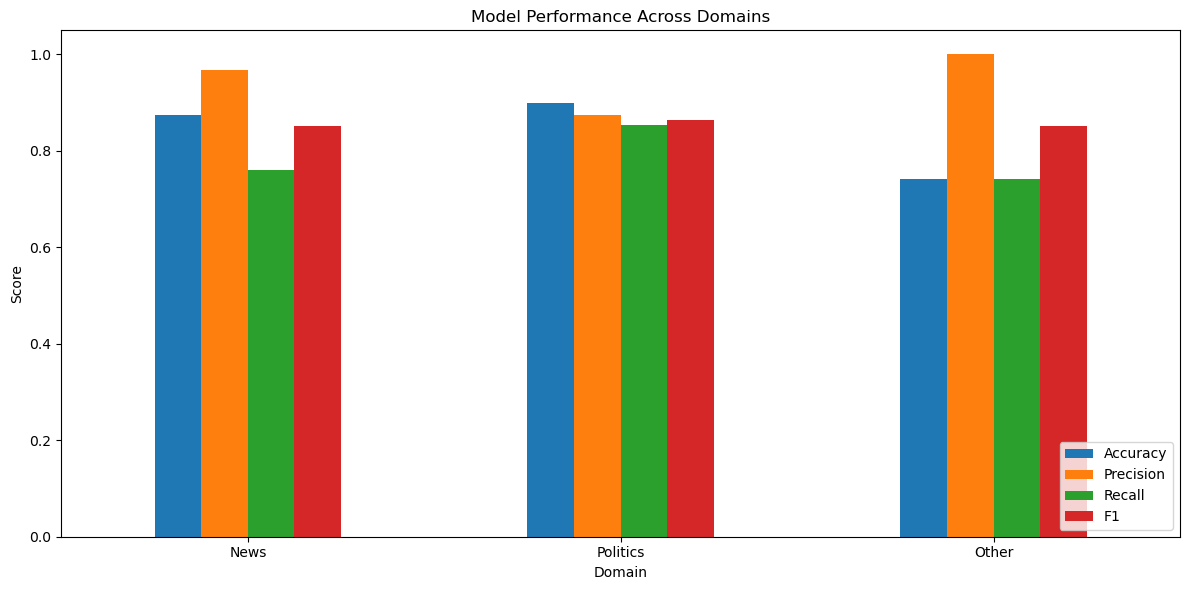

In [14]:
# Domain-specific performance metrics
metrics_df = pd.DataFrame(domain_metrics).T
plt.figure(figsize=(12, 8))
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Across Domains')
plt.ylabel('Score')
plt.xlabel('Domain')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Feature Importance Analysis by Domain:


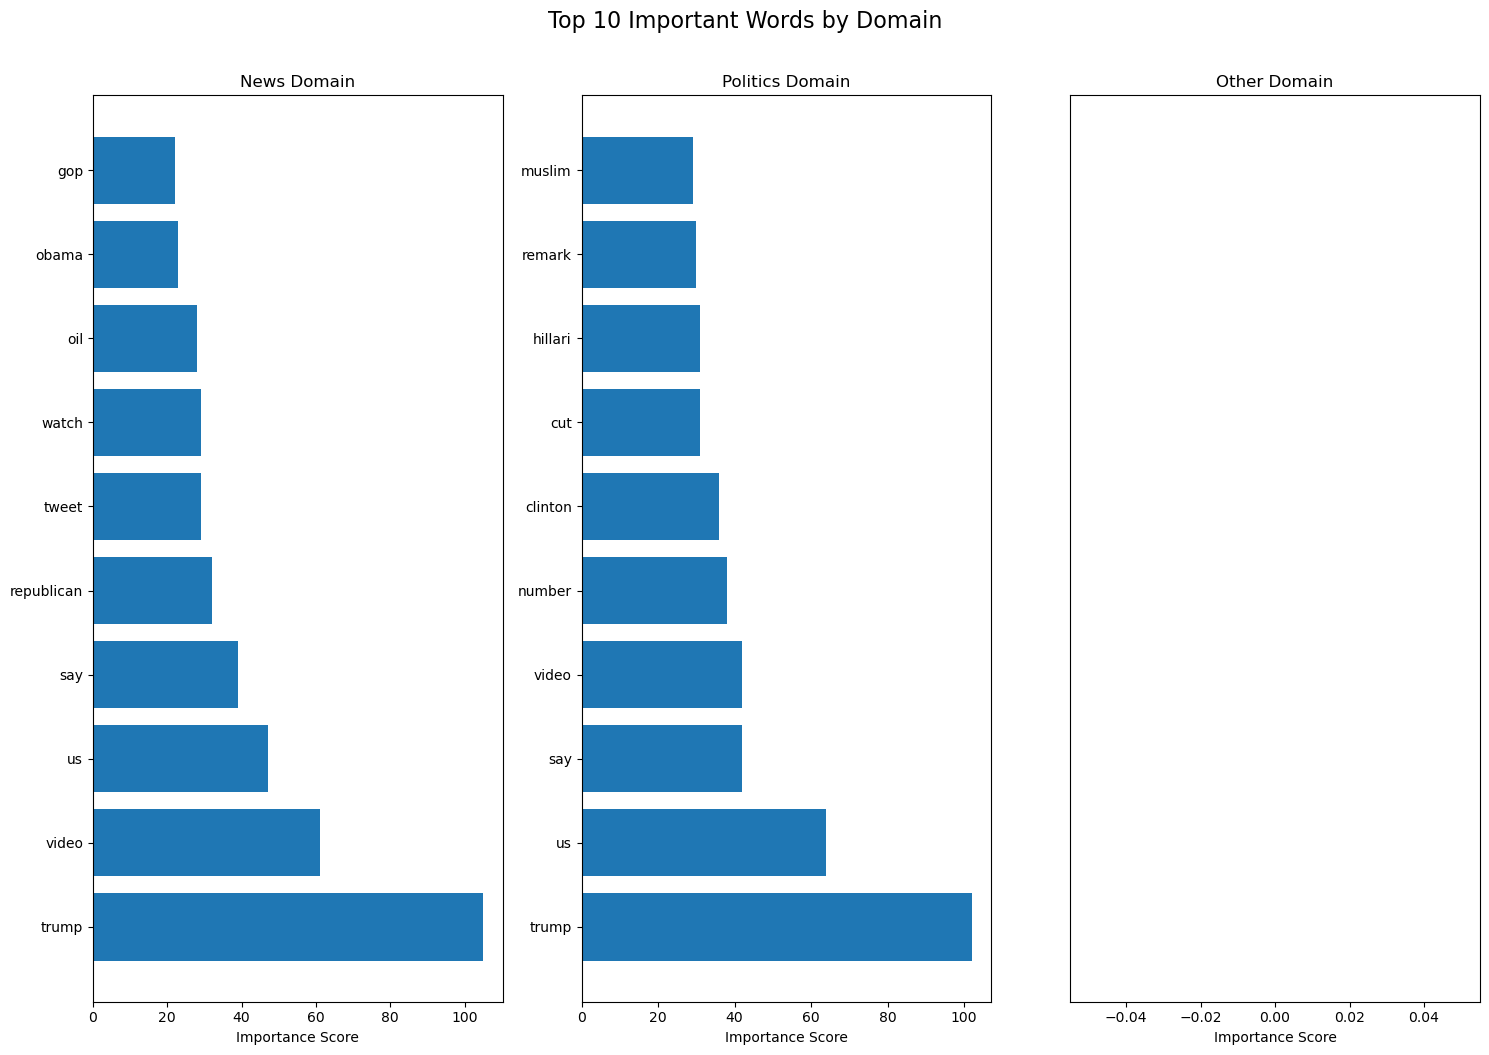

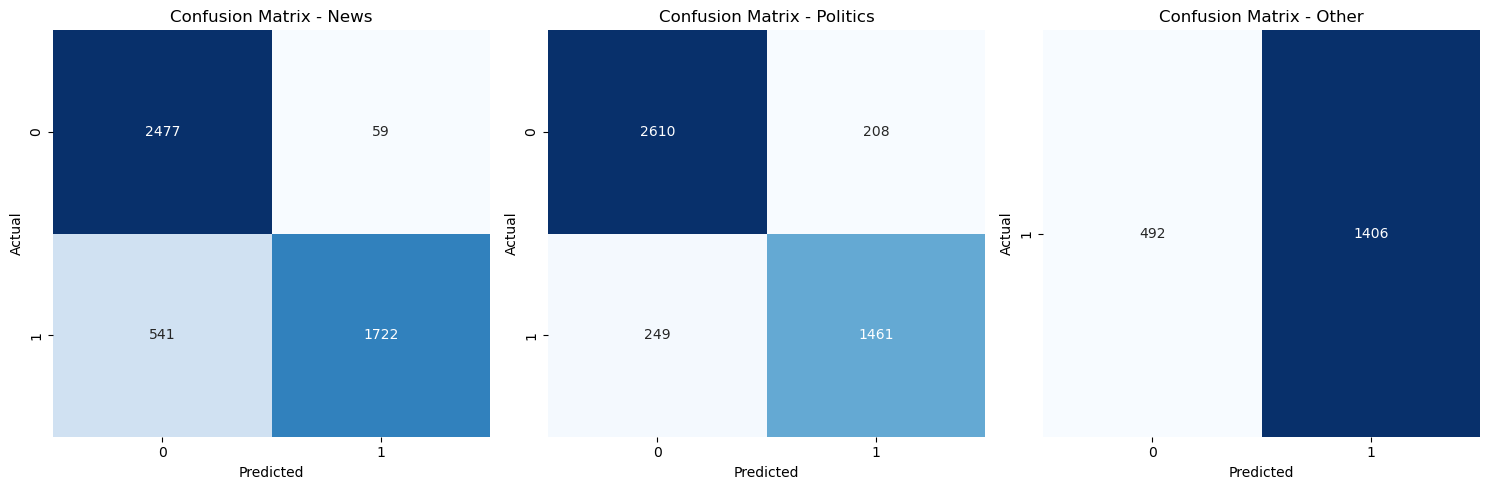

In [15]:
# Feature importance analysis by domain
print("\nFeature Importance Analysis by Domain:")

# Overall feature importance
importance = xgb_model.get_score(importance_type='weight')
word_importance = {}
for feature_idx, importance_score in importance.items():
    idx = int(feature_idx.replace('f', ''))
    if idx < len(feature_names):
        word = feature_names[idx]
        word_importance[word] = importance_score

# Function to analyze domain-specific feature importance
def analyze_domain_features(domain_name):
    domain_train = X_train[X_train['subject'] == domain_name]
    domain_y_train = y_train[domain_train.index]
    
    # Domain-specific vectorizer
    domain_vectorizer = CountVectorizer(min_df=3)
    domain_X_train = domain_vectorizer.fit_transform(domain_train['processed_text'])
    domain_feature_names = domain_vectorizer.get_feature_names_out()
    
    # Domain-specific model
    domain_dtrain = xgb.DMatrix(domain_X_train, label=domain_y_train)
    domain_model = xgb.train(params, domain_dtrain, num_boost_round=100)
    
    # Domain-specific feature importance
    domain_importance = domain_model.get_score(importance_type='weight')
    domain_word_importance = {}
    for feature_idx, importance_score in domain_importance.items():
        idx = int(feature_idx.replace('f', ''))
        if idx < len(domain_feature_names):
            word = domain_feature_names[idx]
            domain_word_importance[word] = importance_score
    
    return domain_word_importance

# Comparison of top features across domains
plt.figure(figsize=(15, 10))
domain_top_words = {}

for i, domain in enumerate(domains):
    domain_importance = analyze_domain_features(domain)
    sorted_domain_importance = sorted(domain_importance.items(), key=lambda x: x[1], reverse=True)
    domain_top_words[domain] = {word: score for word, score in sorted_domain_importance[:10]}
    
    plt.subplot(1, 3, i+1)
    words = [item[0] for item in sorted_domain_importance[:10]]
    scores = [item[1] for item in sorted_domain_importance[:10]]
    
    plt.barh(range(len(words)), scores, align='center')
    plt.yticks(range(len(words)), words)
    plt.xlabel('Importance Score')
    plt.title(f'{domain} Domain')

plt.tight_layout()
plt.suptitle('Top 10 Important Words by Domain', fontsize=16, y=1.05)
plt.show()

# confusion matrix for each domain
plt.figure(figsize=(15, 5))
for i, domain in enumerate(domains):
    domain_data = test_results[test_results['subject'] == domain]
    if len(domain_data) > 0:
        plt.subplot(1, 3, i+1)
        cm = pd.crosstab(domain_data['true_label'], domain_data['predicted_label'], 
                         rownames=['Actual'], colnames=['Predicted'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - {domain}')

plt.tight_layout()
plt.show()

### Domain Coverage Limitation

The absence of feature importance results for the "Other" domain reveals a critical dataset imbalance: this domain appears exclusively in fake news samples and is completely missing from true news examples. This one-sided distribution creates a perfect but potentially misleading signal (100% precision but lower recall), as the model may simply learn to classify all "Other" content as fake. This finding highlights the importance of balanced domain representation across both classes, which will be addressed in the improved approach through better sampling or domain-adaptive techniques.